## Part 2: Generating New Fashion using VAEs

In [8]:
## load the libraries 
import sys
import warnings
import os
import glob
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.metrics import *
from keras.optimizers import Adam, RMSprop
from scipy.stats import norm
from keras.preprocessing import image
from keras import datasets

from keras import backend as K

from imgaug import augmenters
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Understanding VAE

### load dataset

In [24]:
### read dataset 
## Download the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

train_x = x_train
val_x = x_test


In [25]:
## normalize and reshape
train_x = train_x/255.
val_x = val_x/255.

train_x = train_x.reshape(-1, 28, 28, 1)
val_x = val_x.reshape(-1, 28, 28, 1)

### Setup Encoder Neural Network


In [26]:
import keras.backend as K

In [27]:
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters

input_img = Input(shape=(784,), name="input")
x = Dense(512, activation='relu', name="intermediate_encoder")(input_img)
x = Dense(2, activation='relu', name="latent_encoder")(x)

z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [28]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [29]:
# decoder takes the latent distribution sample as input
decoder_input = Input((2,), name="input_decoder")

x = Dense(512, activation='relu', name="intermediate_decoder", input_shape=(2,))(decoder_input)

# Expand to 784 total pixels
x = Dense(784, activation='sigmoid', name="original_decoder")(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [30]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_decoder (InputLayer)   (None, 2)                 0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 512)               1536      
_________________________________________________________________
original_decoder (Dense)     (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [31]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = binary_crossentropy(x, z_decoded)
        return xent_loss

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [32]:
z_decoded

<tf.Tensor 'model_2/original_decoder/Sigmoid:0' shape=(?, 784) dtype=float32>

In [33]:
# VAE model statement
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

In [34]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 784)          0                                            
__________________________________________________________________________________________________
intermediate_encoder (Dense)    (None, 512)          401920      input[0][0]                      
__________________________________________________________________________________________________
latent_encoder (Dense)          (None, 2)            1026        intermediate_encoder[0][0]       
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            6           latent_encoder[0][0]             
__________________________________________________________________________________________________
dense_2 (D

In [35]:
train_x.shape

(60000, 28, 28, 1)

In [36]:
train_x = train_x.reshape(-1, 784)
val_x = val_x.reshape(-1, 784)

In [37]:
vae.fit(x=train_x, y=None,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(val_x, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 30s 508us/step - loss: 0.4925 - val_loss: 0.4914
Epoch 2/20
60000/60000 [==============================] - 31s 513us/step - loss: 0.4907 - val_loss: 0.4912
Epoch 3/20
60000/60000 [==============================] - 31s 510us/step - loss: 0.4906 - val_loss: 0.4917
Epoch 4/20
60000/60000 [==============================] - 30s 502us/step - loss: 0.4905 - val_loss: 0.4913
Epoch 5/20
60000/60000 [==============================] - 31s 512us/step - loss: 0.4905 - val_loss: 0.4912
Epoch 6/20
60000/60000 [==============================] - 31s 512us/step - loss: 0.4905 - val_loss: 0.4913
Epoch 7/20
60000/60000 [==============================] - 30s 507us/step - loss: 0.4905 - val_loss: 0.4914
Epoch 8/20
60000/60000 [==============================] - 30s 508us/step - loss: 0.4904 - val_loss: 0.4915
Epoch 9/20
60000/60000 [==============================] - 31s 513us/step - loss: 0.4904 - val_

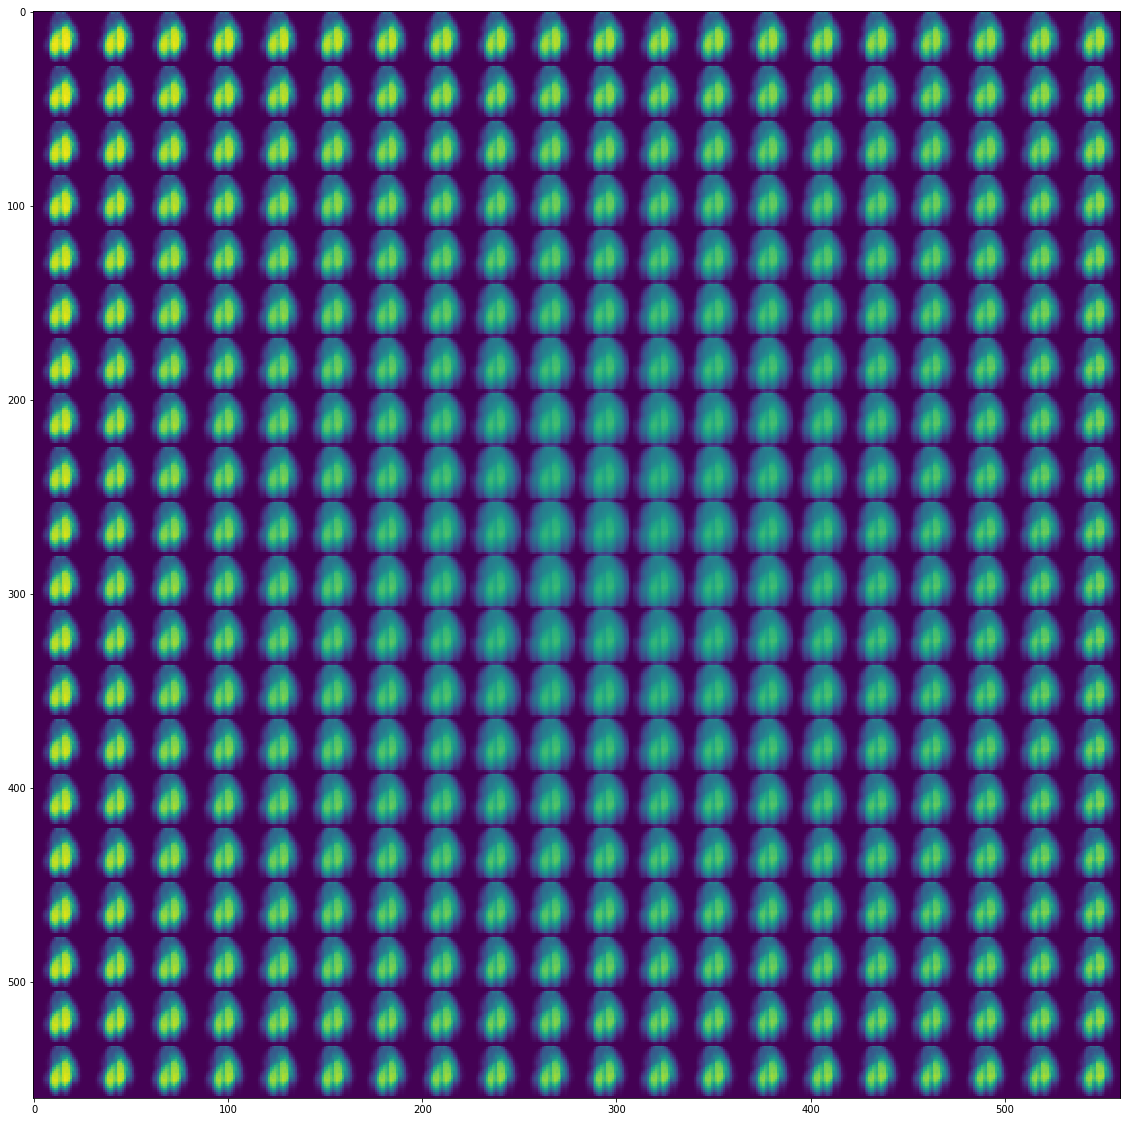

In [42]:
# Display a 2D manifold of the samples
n = 20  # figure with 20x20 samples
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values - can change values here to generate different things
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
plt.imshow(figure)
plt.show() 